In [71]:
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from beakerx import *
plt.style.use('ggplot')
import seaborn as sns
sns.set()
import h5py
import os
from tqdm import tqdm_notebook as tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
from scipy.io import loadmat
from matplotlib.mlab import griddata
tableau20 = np.array([(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)])/255.
styles = ["white","dark",'whitegrid',"darkgrid"]
contexts = ['paper','talk','poster','notebook']
from ipywidgets import interact, FloatSlider,IntSlider, RadioButtons,Dropdown,Tab,Text,SelectMultiple,FloatRangeSlider
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from mpl_toolkits.mplot3d.axes3d import *
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler

Populating the interactive namespace from numpy and matplotlib


In [70]:
sklearn.preprocessing?

In [3]:
cd /home/xupeng/projects/signal

/home/xupeng/projects/signal


In [4]:
ls data/

citydata.mat  data_cross  data_cross_250  data_paper_WSNL/


In [8]:
rawdata = loadmat('data/citydata.mat')

In [11]:
rawdata.keys()

dict_keys(['__header__', '__version__', '__globals__', 'RX', 'RSS', 'TOA', 'RSS_t', 'TX', 'DOA'])

In [19]:
featurename = ['RSS', 'TOA', 'DOA']
machinename = ['RX', 'TX']

In [20]:
for i in featurename:
    print (i,rawdata[i].shape)
for i in machinename:
    print (i,rawdata[i].shape)

RSS (1500, 100)
TOA (1500, 100)
DOA (1500, 300)
RX (1500, 3)
TX (100, 3)


In [60]:
RSS = rawdata['RSS']
TOA = rawdata['TOA']
DOA = rawdata['DOA']

In [22]:
TXloc = rawdata['TX']
RXloc = rawdata['RX']

(array([  7., 218., 395.,   0., 299., 251.,   0., 188., 125.,  17.]),
 array([22.01, 22.71, 23.41, 24.11, 24.81, 25.51, 26.21, 26.91, 27.61,
        28.31, 29.01]),
 <a list of 10 Patch objects>)

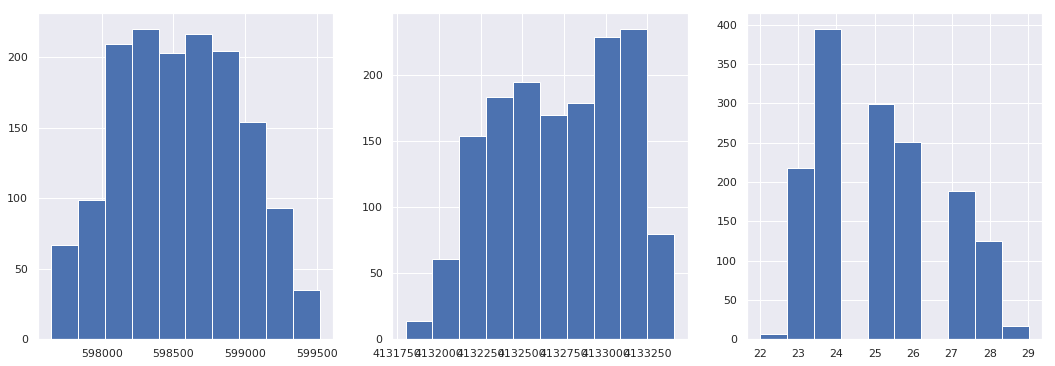

In [28]:
fig,ax=plt.subplots(1,3,figsize=(18,6))
ax[0].hist(RXloc[:,0])
ax[1].hist(RXloc[:,1])
ax[2].hist(RXloc[:,2])

(array([63., 19.,  8.,  4.,  2.,  1.,  2.,  0.,  0.,  1.]),
 array([27.   , 31.455, 35.91 , 40.365, 44.82 , 49.275, 53.73 , 58.185,
        62.64 , 67.095, 71.55 ]),
 <a list of 10 Patch objects>)

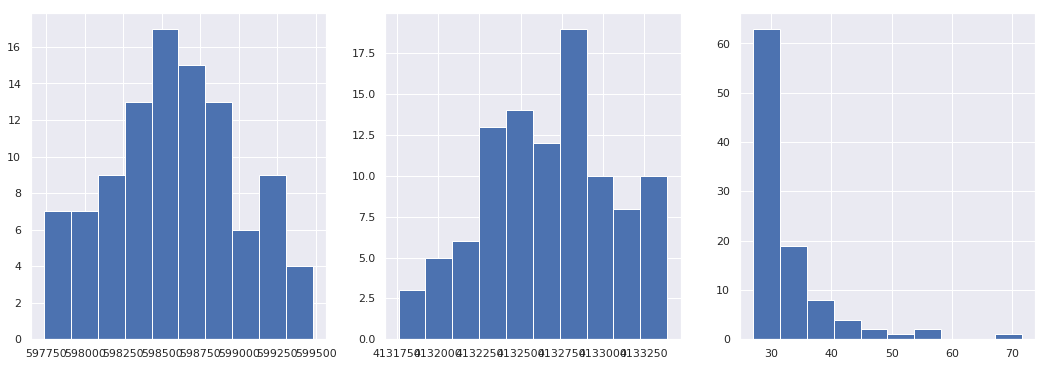

In [38]:
fig,ax=plt.subplots(1,3,figsize=(18,6))
ax[0].hist(TXloc[:,0])
ax[1].hist(TXloc[:,1])
ax[2].hist(TXloc[:,2])

In [39]:
np.min(RXloc[:,0]),np.min(RXloc[:,1]),np.min(TXloc[:,0]),np.min(TXloc[:,1])

(597648.0, 4131801.0, 597735.7413369685, 4131760.764775589)

In [41]:
xyzorigin_RX = np.array([np.min(RXloc[:,0]),np.min(RXloc[:,1]),0])
xyzorigin_TX = np.array([np.min(TXloc[:,0]),np.min(TXloc[:,1]),0])
RXloc_shifted = RXloc - xyzorigin_RX
TXloc_shifted = TXloc - xyzorigin_TX

(array([  7., 218., 395.,   0., 299., 251.,   0., 188., 125.,  17.]),
 array([22.01, 22.71, 23.41, 24.11, 24.81, 25.51, 26.21, 26.91, 27.61,
        28.31, 29.01]),
 <a list of 10 Patch objects>)

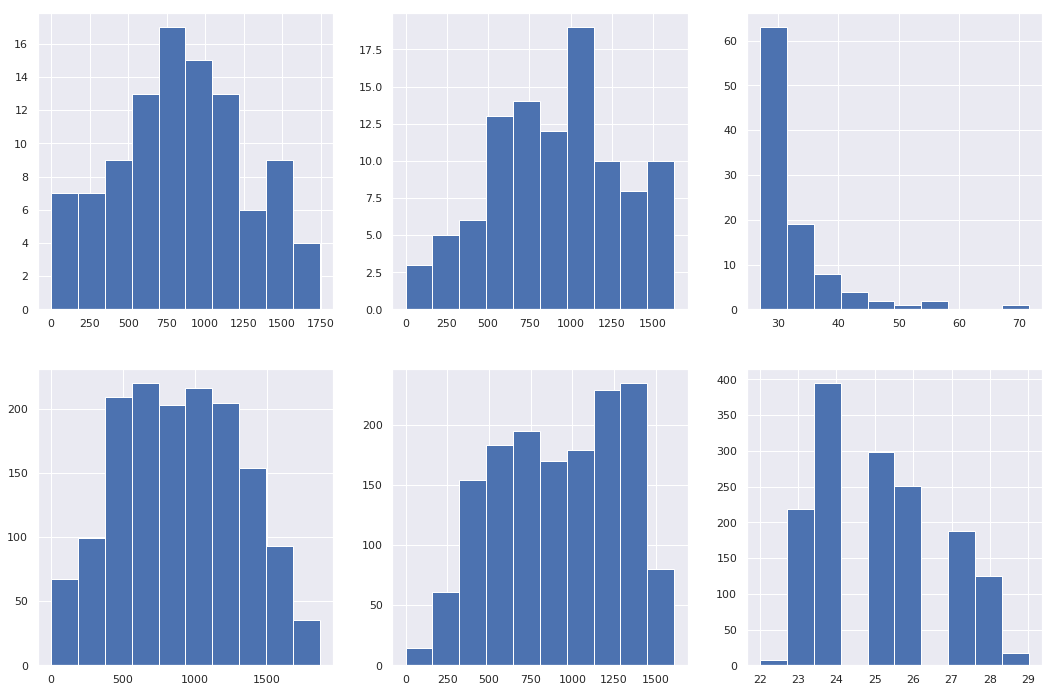

In [45]:
fig,ax=plt.subplots(2,3,figsize=(18,12))
ax[0,0].hist(TXloc_shifted[:,0])
ax[0,1].hist(TXloc_shifted[:,1])
ax[0,2].hist(TXloc_shifted[:,2])
ax[1,0].hist(RXloc_shifted[:,0])
ax[1,1].hist(RXloc_shifted[:,1])
ax[1,2].hist(RXloc_shifted[:,2])

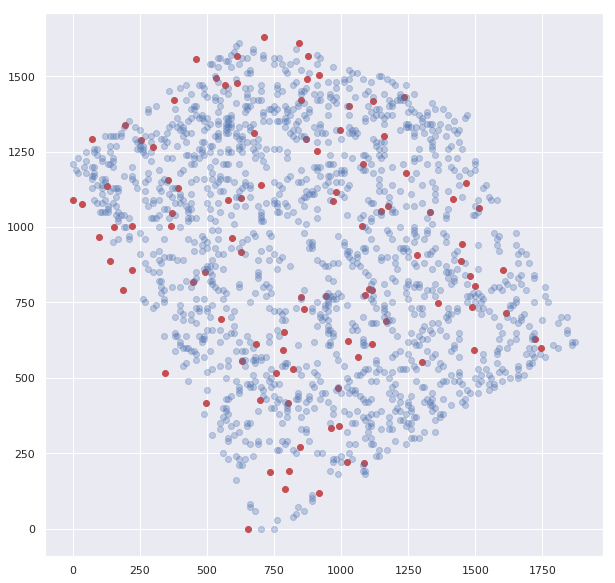

In [48]:
fig,ax = plt.subplots(1,figsize=(10,10))
ax.scatter(TXloc_shifted[:,0],TXloc_shifted[:,1],color='r')
ax.scatter(RXloc_shifted[:,0],RXloc_shifted[:,1],color='b',alpha=0.3)

- feature 
    - RSS, TOA,DOA 是feature， 共1500个receiver(RX), 100个transmitter(TX), DOA是1500*300 因为每个RX收到的信号的角度是用这个信号和x,y,z轴的夹角的余弦表示的，所以一个角度用三个数值表示，100个TX就是300个数值。
- RX, TX
    - 对于RX的坐标和TX坐标你可能需要平移处理下，否则太大了。
- <span class="mark">DATA imputation</span>
    - 数据有缺失，需要做imputation
    - 比较不同的imputation方法
- normalization
    - robustscaler
- <span class="mark">Feature selection</span>
    - 留下20个以内
        - 先直接选再imputation
        - 先imputation再用feature selection选20个
        - 先imputation再根据最初的20个最好的选
    - transmitter 100个，导致feature维度很高
    - 对于不同的receiver，比较远的transmitter可能用处不大，但是这些feature对不同的receiver是不固定的
    - TX是3D的，有高度。有的TX的位置很高，所以很多RX都能收到信息
    - RX基本都在同一平面
    - TX要挑出来一些，要保证最后挑出来的feature来自比较均匀分布的TX
    - 比较不同的feature selection方法
- <span class="mark">Model</span>
    - MDN
        - 联合预测xy
        - 联合预测xyz
    - 后续：
        - 考虑用到城市楼房信息
            - (GPS辅助定位文章？)

### 缺失值和留存值

In [107]:
RX_RSS_nan = np.sum(np.isnan(RSS),axis=1)
RX_TOA_nan = np.sum(np.isnan(TOA),axis=1)
RX_DOA_nan = np.sum(np.isnan(DOA),axis=1)
TX_RSS_nan = np.sum(np.isnan(RSS),axis=0)
TX_TOA_nan = np.sum(np.isnan(TOA),axis=0)
TX_DOA_nan = np.sum(np.isnan(DOA),axis=0)
RX_RSS_remain = 100 - RX_RSS_nan
RX_TOA_remain = 100 - RX_RSS_nan
RX_DOA_remain = 300 - RX_RSS_nan
TX_RSS_remain = 1500 - TX_RSS_nan
TX_TOA_remain = 1500 - TX_RSS_nan
TX_DOA_remain = 1500 - TX_RSS_nan

In [99]:
RX_RSS_nan.shape

(1500,)

(array([99., 96., 45., 30., 18.,  3.,  6.,  0.,  0.,  3.]),
 array([   6. ,  134.7,  263.4,  392.1,  520.8,  649.5,  778.2,  906.9,
        1035.6, 1164.3, 1293. ]),
 <a list of 10 Patch objects>)

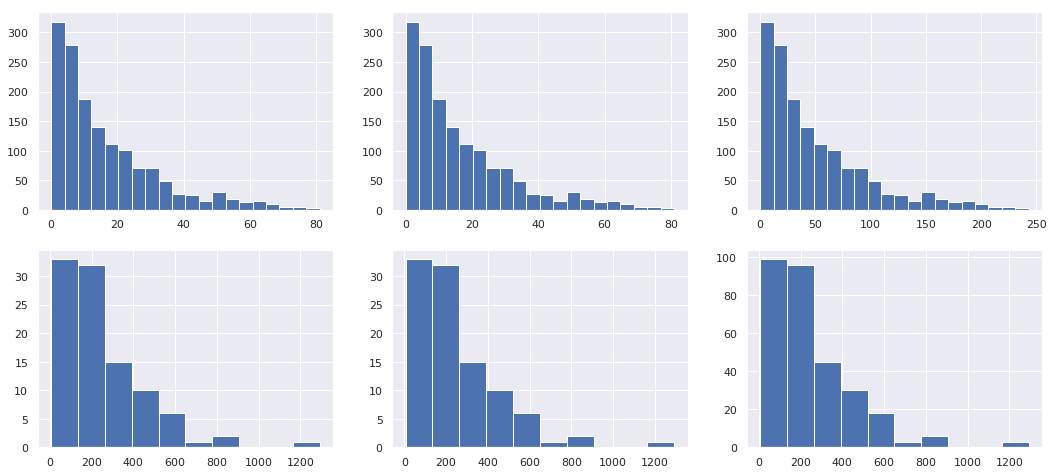

In [98]:
fig,ax=plt.subplots(2,3,figsize=(18,8))
ax[0,0].hist(RX_RSS_nan,bins=20)
ax[0,1].hist(RX_TOA_nan,bins=20)
ax[0,2].hist(RX_DOA_nan,bins=20)
ax[1,0].hist(TX_RSS_nan,bins=10)
ax[1,1].hist(TX_TOA_nan,bins=10)
ax[1,2].hist(TX_DOA_nan,bins=10)

(array([  9.,  16.,  28.,  49.,  41.,  77., 142., 213., 328., 597.]),
 array([1419. , 1427.1, 1435.2, 1443.3, 1451.4, 1459.5, 1467.6, 1475.7,
        1483.8, 1491.9, 1500. ]),
 <a list of 10 Patch objects>)

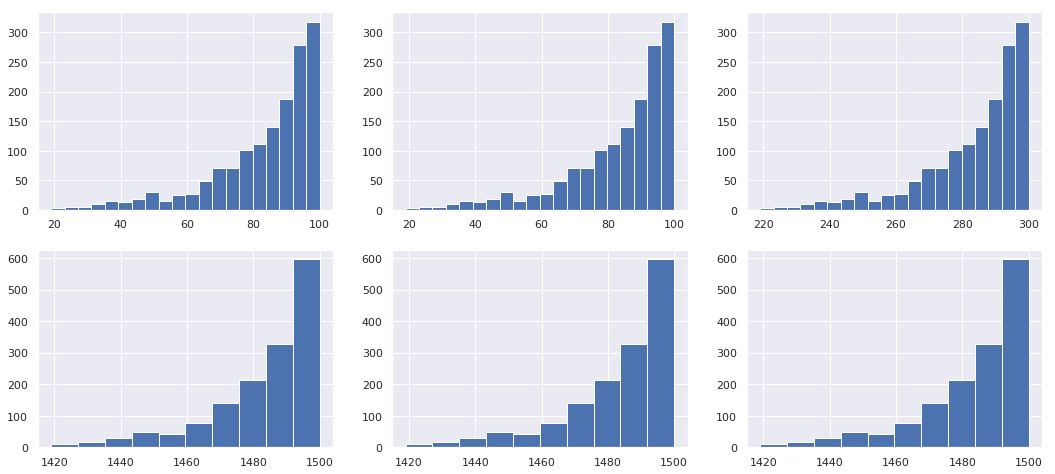

In [101]:
fig,ax=plt.subplots(2,3,figsize=(18,8))
ax[0,0].hist(RX_RSS_remain,bins=20)
ax[0,1].hist(RX_TOA_remain,bins=20)
ax[0,2].hist(RX_DOA_remain,bins=20)
ax[1,0].hist(TX_RSS_remain,bins=10)
ax[1,1].hist(TX_TOA_remain,bins=10)
ax[1,2].hist(TX_DOA_remain,bins=10)

In [109]:
TX_RSS_remain.shape,RX_RSS_remain.shape

((100,), (1500,))

In [120]:
def plot_remain_features(data,dtype='RX'):
    fig,ax=plt.subplots(1,figsize=(20,6))
    if dtype=='TX':      
        counttable =  pd.DataFrame(np.concatenate((np.arange(1,101).reshape(-1,1),np.flip(np.sort(data),axis=0).reshape(-1,1)),axis=1),columns=['sample','remain'])
        sns.barplot(x='sample',y='remain',data = counttable,color='b',alpha=0.5)  
        ax.set_xticks(np.arange(0,110,10))
        ax.set_xticklabels(np.arange(0,110,10))
    else:
        #counttable =  pd.DataFrame(np.concatenate((np.arange(1,1501).reshape(-1,1),np.flip(np.sort(data),axis=0).reshape(-1,1)),axis=1),columns=['sample','remain'])
        ax.plot(np.flip(np.sort(data),axis=0))  
        ax.set_xticks(np.arange(0,1510,50))
        ax.set_xticklabels(np.arange(0,1510,10))
    
    ax.set_title('remain feature nums')
    

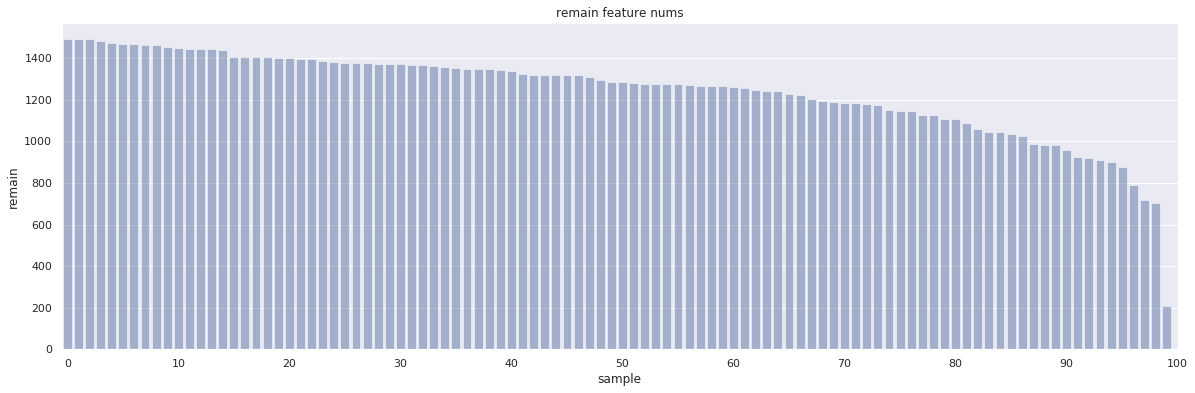

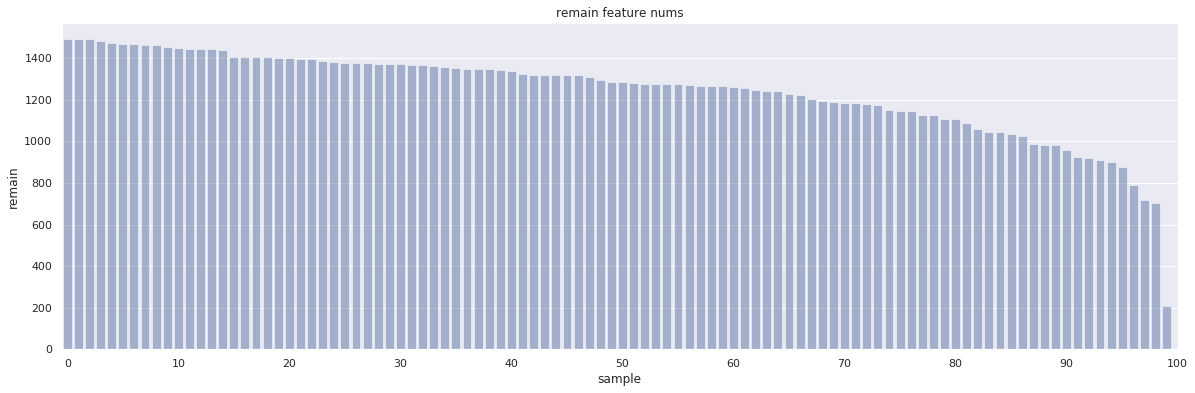

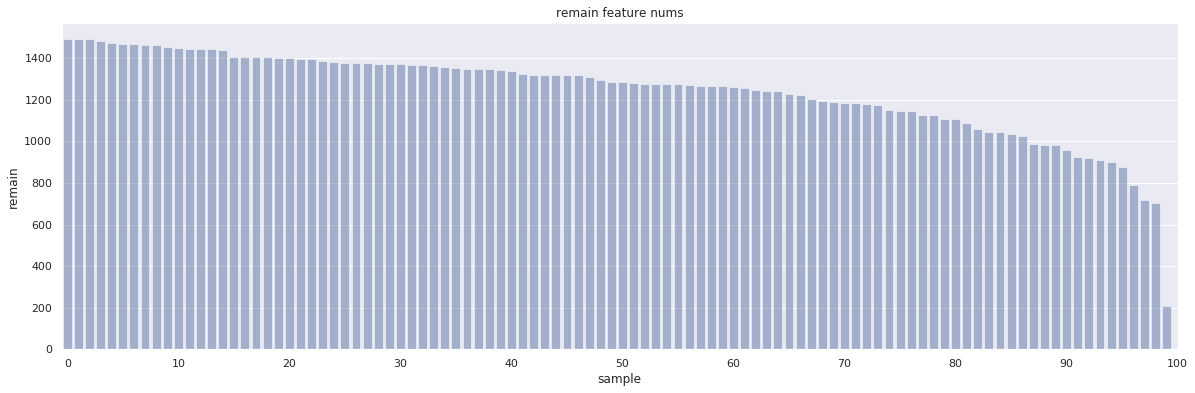

In [117]:
plot_remain_features(TX_RSS_remain,dtype='TX')
plot_remain_features(TX_TOA_remain,dtype='TX')
plot_remain_features(TX_DOA_remain,dtype='TX')

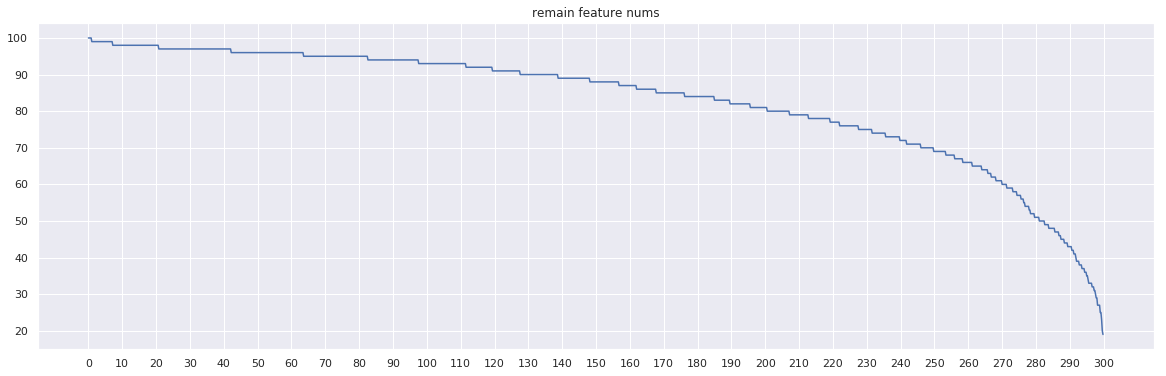

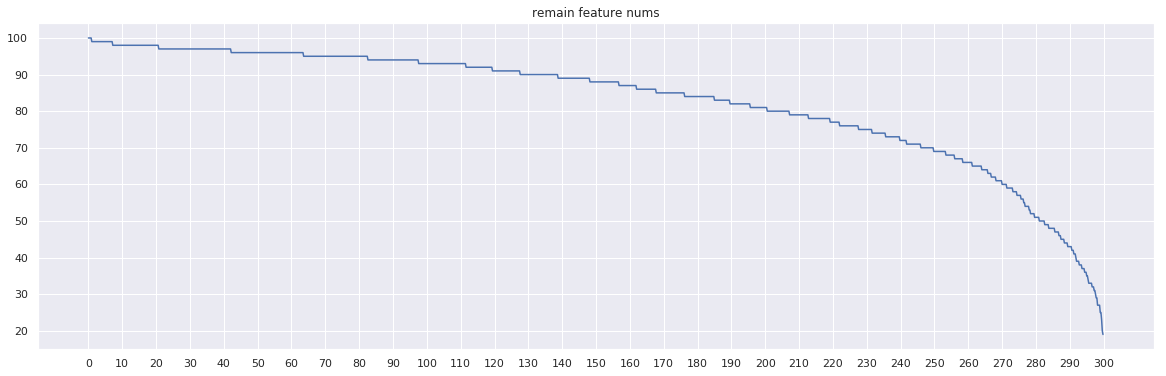

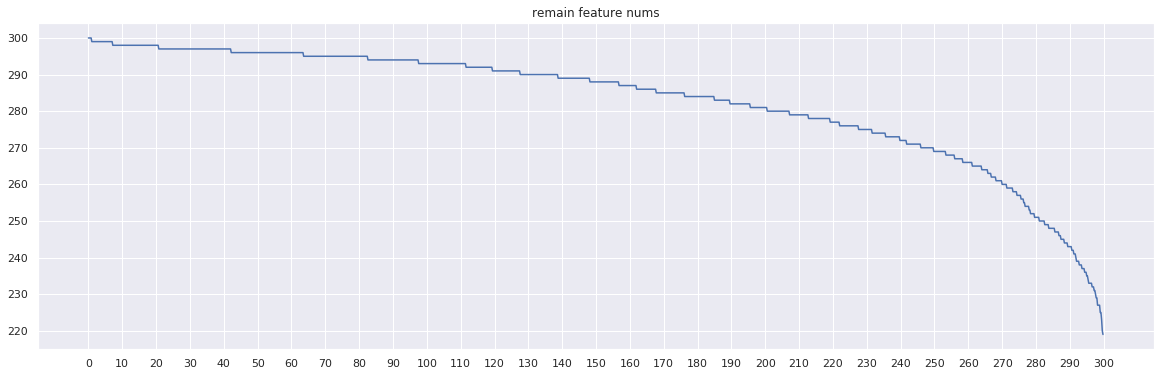

In [122]:
plot_remain_features(RX_RSS_remain,dtype='RX')
plot_remain_features(RX_TOA_remain,dtype='RX')
plot_remain_features(RX_DOA_remain,dtype='RX')

#### TX 3D

In [123]:
def plot_3d_grid_surface(data,width,height,azim,elev,contextind,styind,option):
    sns.set_context(contexts[int(contextind)])
    sns.set_style(styles[int(styind)])
    fig = plt.figure(figsize=(width,height))
    if data=='RX':
        loc = RXloc_shifted
    else:
        loc = TXloc_shifted
    X = loc[:,0]
    Y = loc[:,1]
    Z = loc[:,2]
    x = X.ravel()
    y = Y.ravel()
    z = Z.ravel()
    xi = np.linspace(min(x), max(x))
    yi = np.linspace(min(y), max(y))
    X, Y = np.meshgrid(xi, yi)
    # interpolation
    Z = griddata(x, y, z, xi, yi,interp='linear')
    ax = Axes3D(fig)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.scatter3D(x,y,z,c=z,cmap=plt.cm.jet)
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.binary_r,linewidth=1, antialiased=True,alpha=0.2) 
    ax.view_init(azim=azim,elev=elev)  # 50 20
    ax.set_title('3D surface '+data)
    fig.tight_layout()
    plt.gca().invert_yaxis()
    if option=='save':
        fig.savefig('3D surface '+data+'.png')
    else:
        plt.show()
interact(plot_3d_grid_surface,
    contextind=FloatSlider(min=0,max=3,step=1,value=2),
         styind=FloatSlider(min=0,max=2,step=1),
    width =FloatSlider(min=4,max=40,step=1,value=25),
    height= FloatSlider(min=4,max=30,step=1,value=16),
    azim= FloatSlider(min=0,max=180,step=2,value=45),
         data= RadioButtons(options=['RX','TX']),
         option= RadioButtons(options=['show','save']),
    elev= FloatSlider(min=0,max=180,step=1,value=32))

interactive(children=(RadioButtons(description='data', options=('RX', 'TX'), value='RX'), FloatSlider(value=25…

<function __main__.plot_3d_grid_surface(data, width, height, azim, elev, contextind, styind, option)>

In [59]:
def plot_3d_grid_surface(data,width,height,azim,elev,contextind,styind,option):
    sns.set_context(contexts[int(contextind)])
    sns.set_style(styles[int(styind)])
    fig = plt.figure(figsize=(width,height))
    if data=='RX':
        loc = RXloc_shifted
    else:
        loc = TXloc_shifted
    X = loc[:,0]
    Y = loc[:,1]
    Z = loc[:,2]
    x = X.ravel()
    y = Y.ravel()
    z = Z.ravel()
    xi = np.linspace(min(x), max(x))
    yi = np.linspace(min(y), max(y))
    X, Y = np.meshgrid(xi, yi)
    # interpolation
    Z = griddata(x, y, z, xi, yi,interp='linear')
    ax = Axes3D(fig)
    ax.scatter3D(x,y,z,c=z,cmap=plt.cm.jet)
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.binary_r,linewidth=1, antialiased=True,alpha=0.2) 
    ax.view_init(azim=azim,elev=elev)  # 50 20
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('3D surface '+data)
    fig.tight_layout()
    if option=='save':
        fig.savefig('3D surface '+data+'.png')
    else:
        plt.show()
interact(plot_3d_grid_surface,
    contextind=FloatSlider(min=0,max=3,step=1,value=2),
         styind=FloatSlider(min=0,max=2,step=1),
    width =FloatSlider(min=4,max=40,step=1,value=25),
    height= FloatSlider(min=4,max=30,step=1,value=16),
    azim= FloatSlider(min=0,max=180,step=2,value=45),
         data= RadioButtons(options=['RX','TX']),
         option= RadioButtons(options=['show','save']),
    elev= FloatSlider(min=0,max=180,step=1,value=32))

interactive(children=(RadioButtons(description='data', options=('RX', 'TX'), value='RX'), FloatSlider(value=25…

<function __main__.plot_3d_grid_surface(data, width, height, azim, elev, contextind, styind, option)>

In [72]:
def simple_process(data):
    '''
    simply convert nan to zero
    scale data
    '''
    datas = np.copy(data)
    datas[np.isnan(datas)]=0
    return RobustScaler().fit_transform(datas)

In [76]:
def simple_process_(data):
    '''
    simply convert nan to zero
    scale data
    '''
    datas = np.copy(data)
    datas[np.isnan(datas)]=0
    return MinMaxScaler().fit_transform(datas)

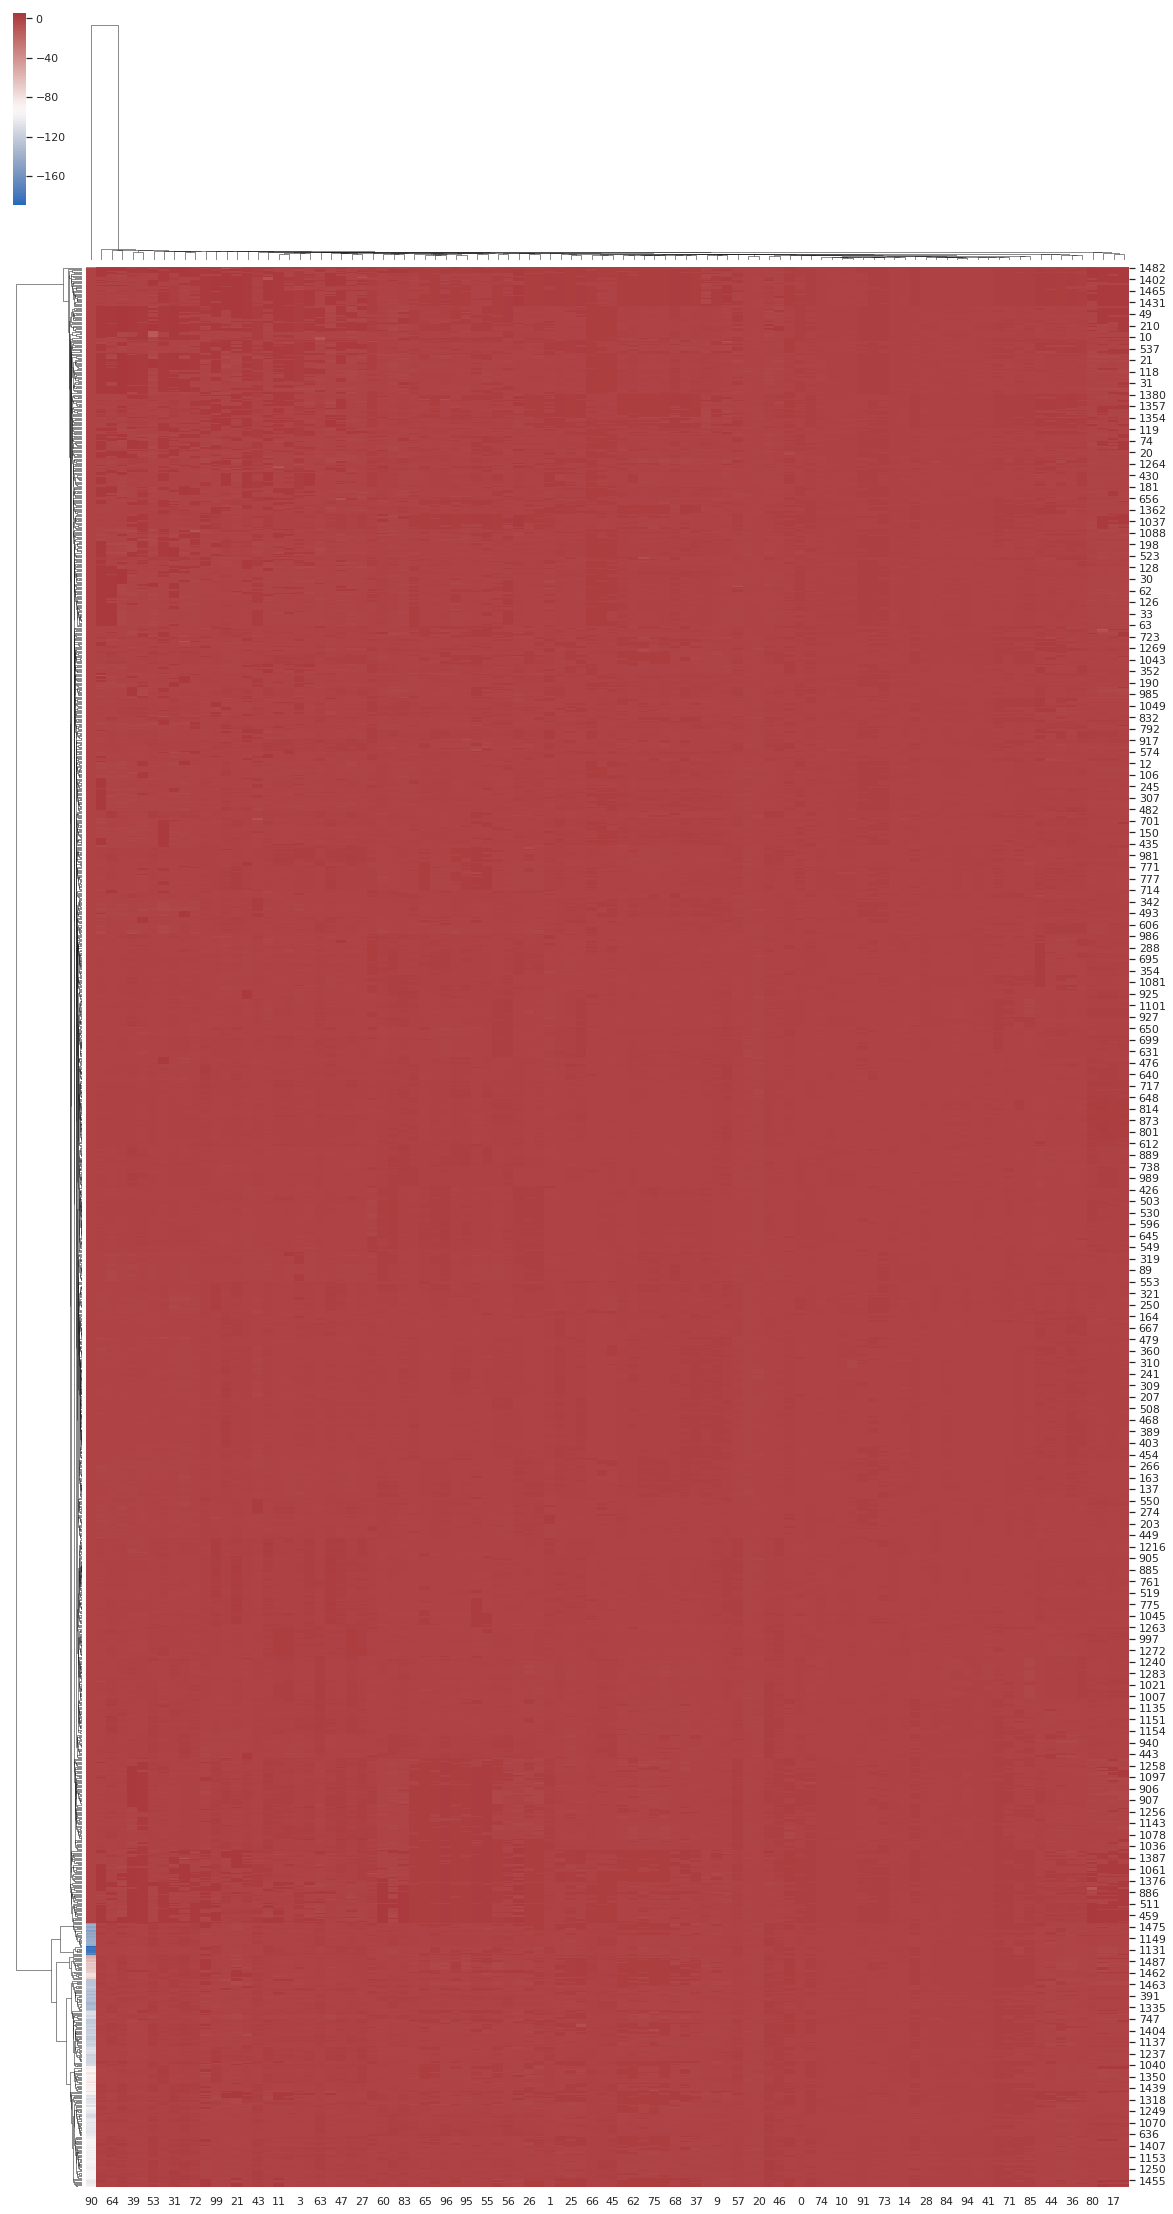

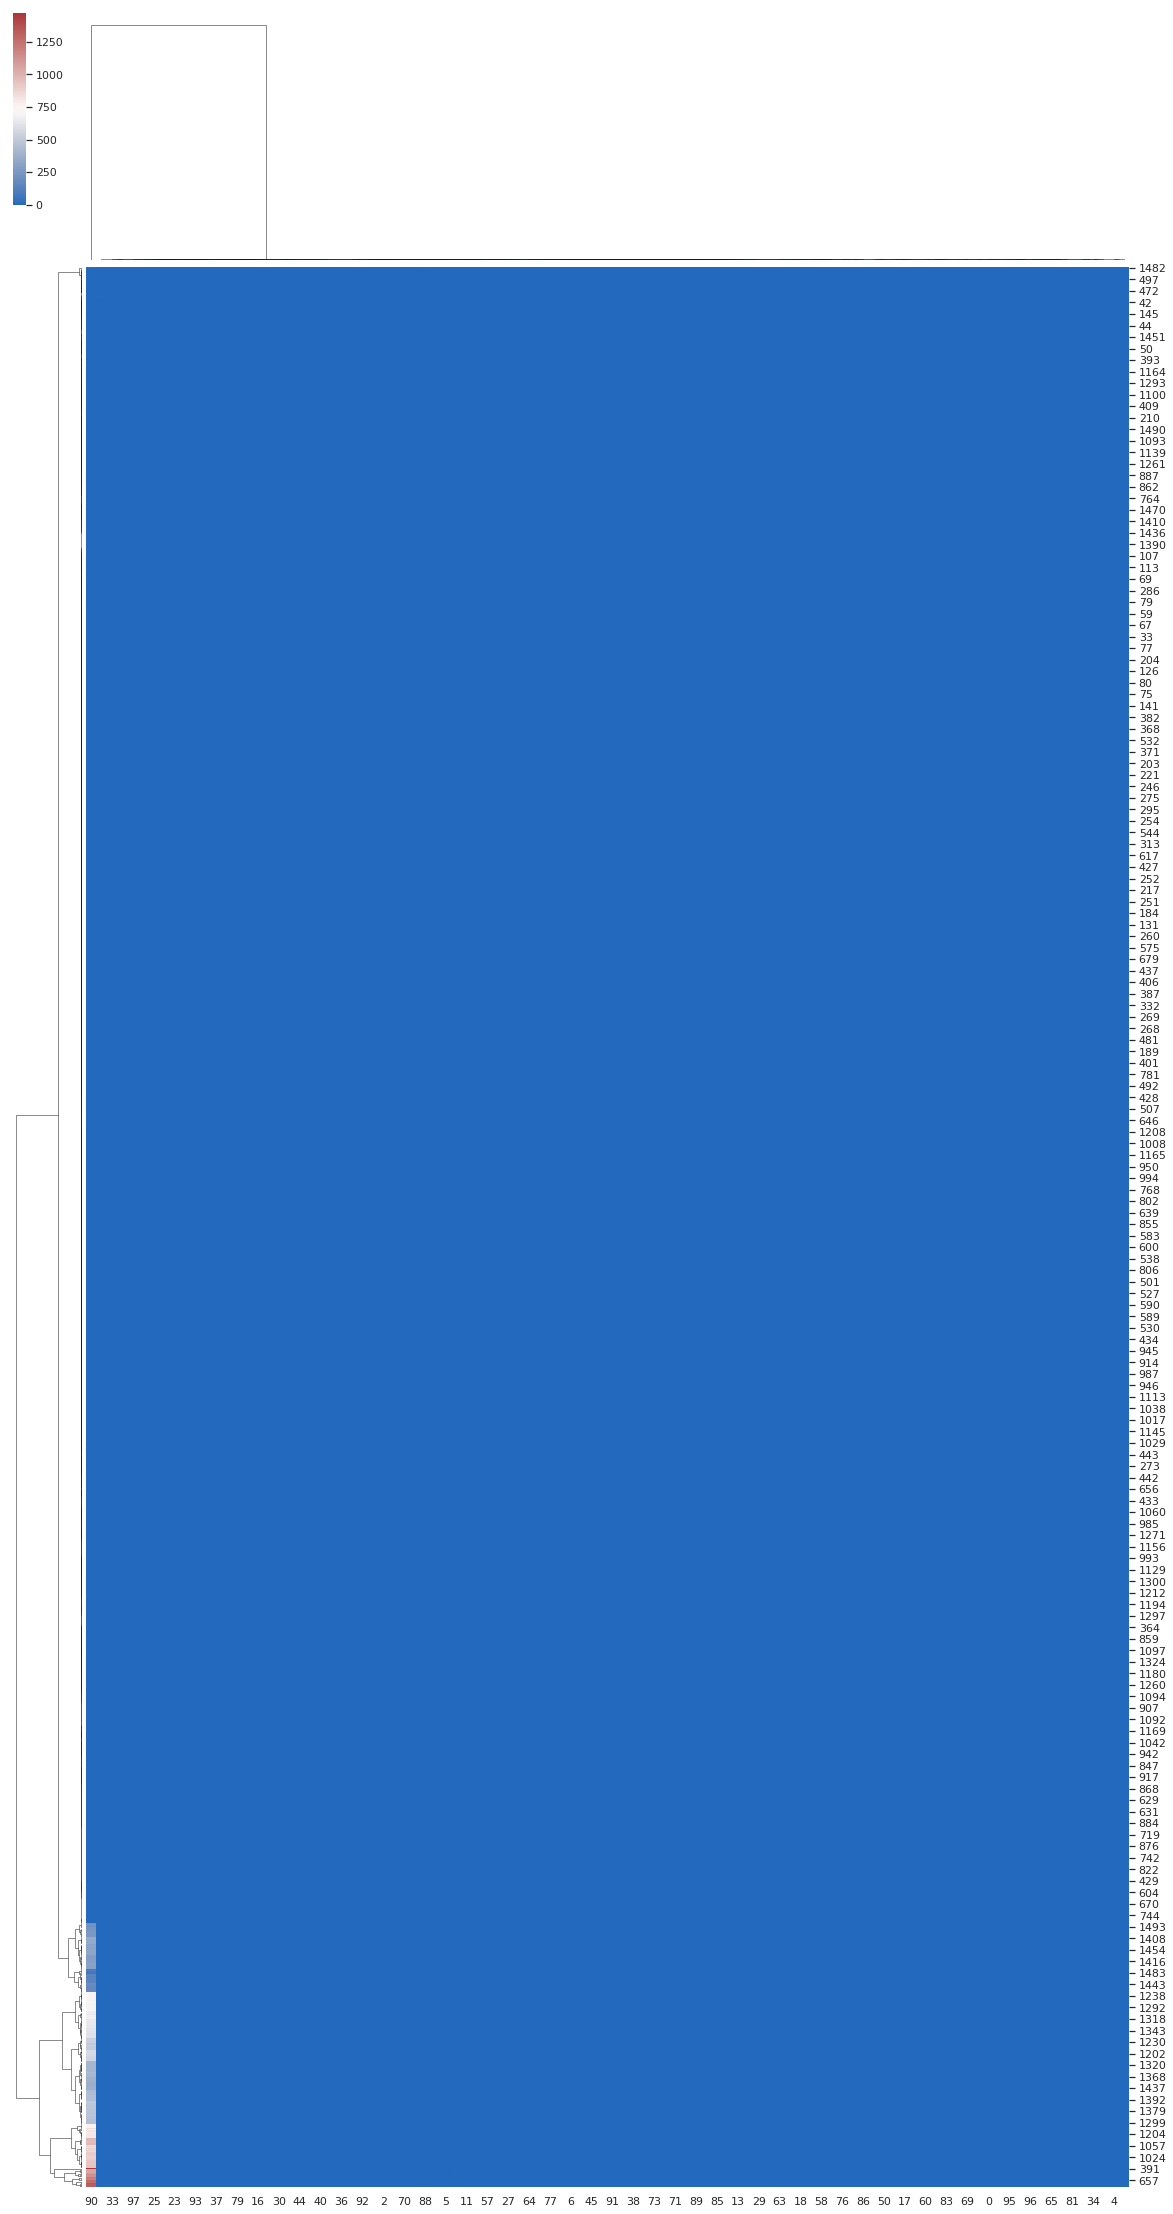

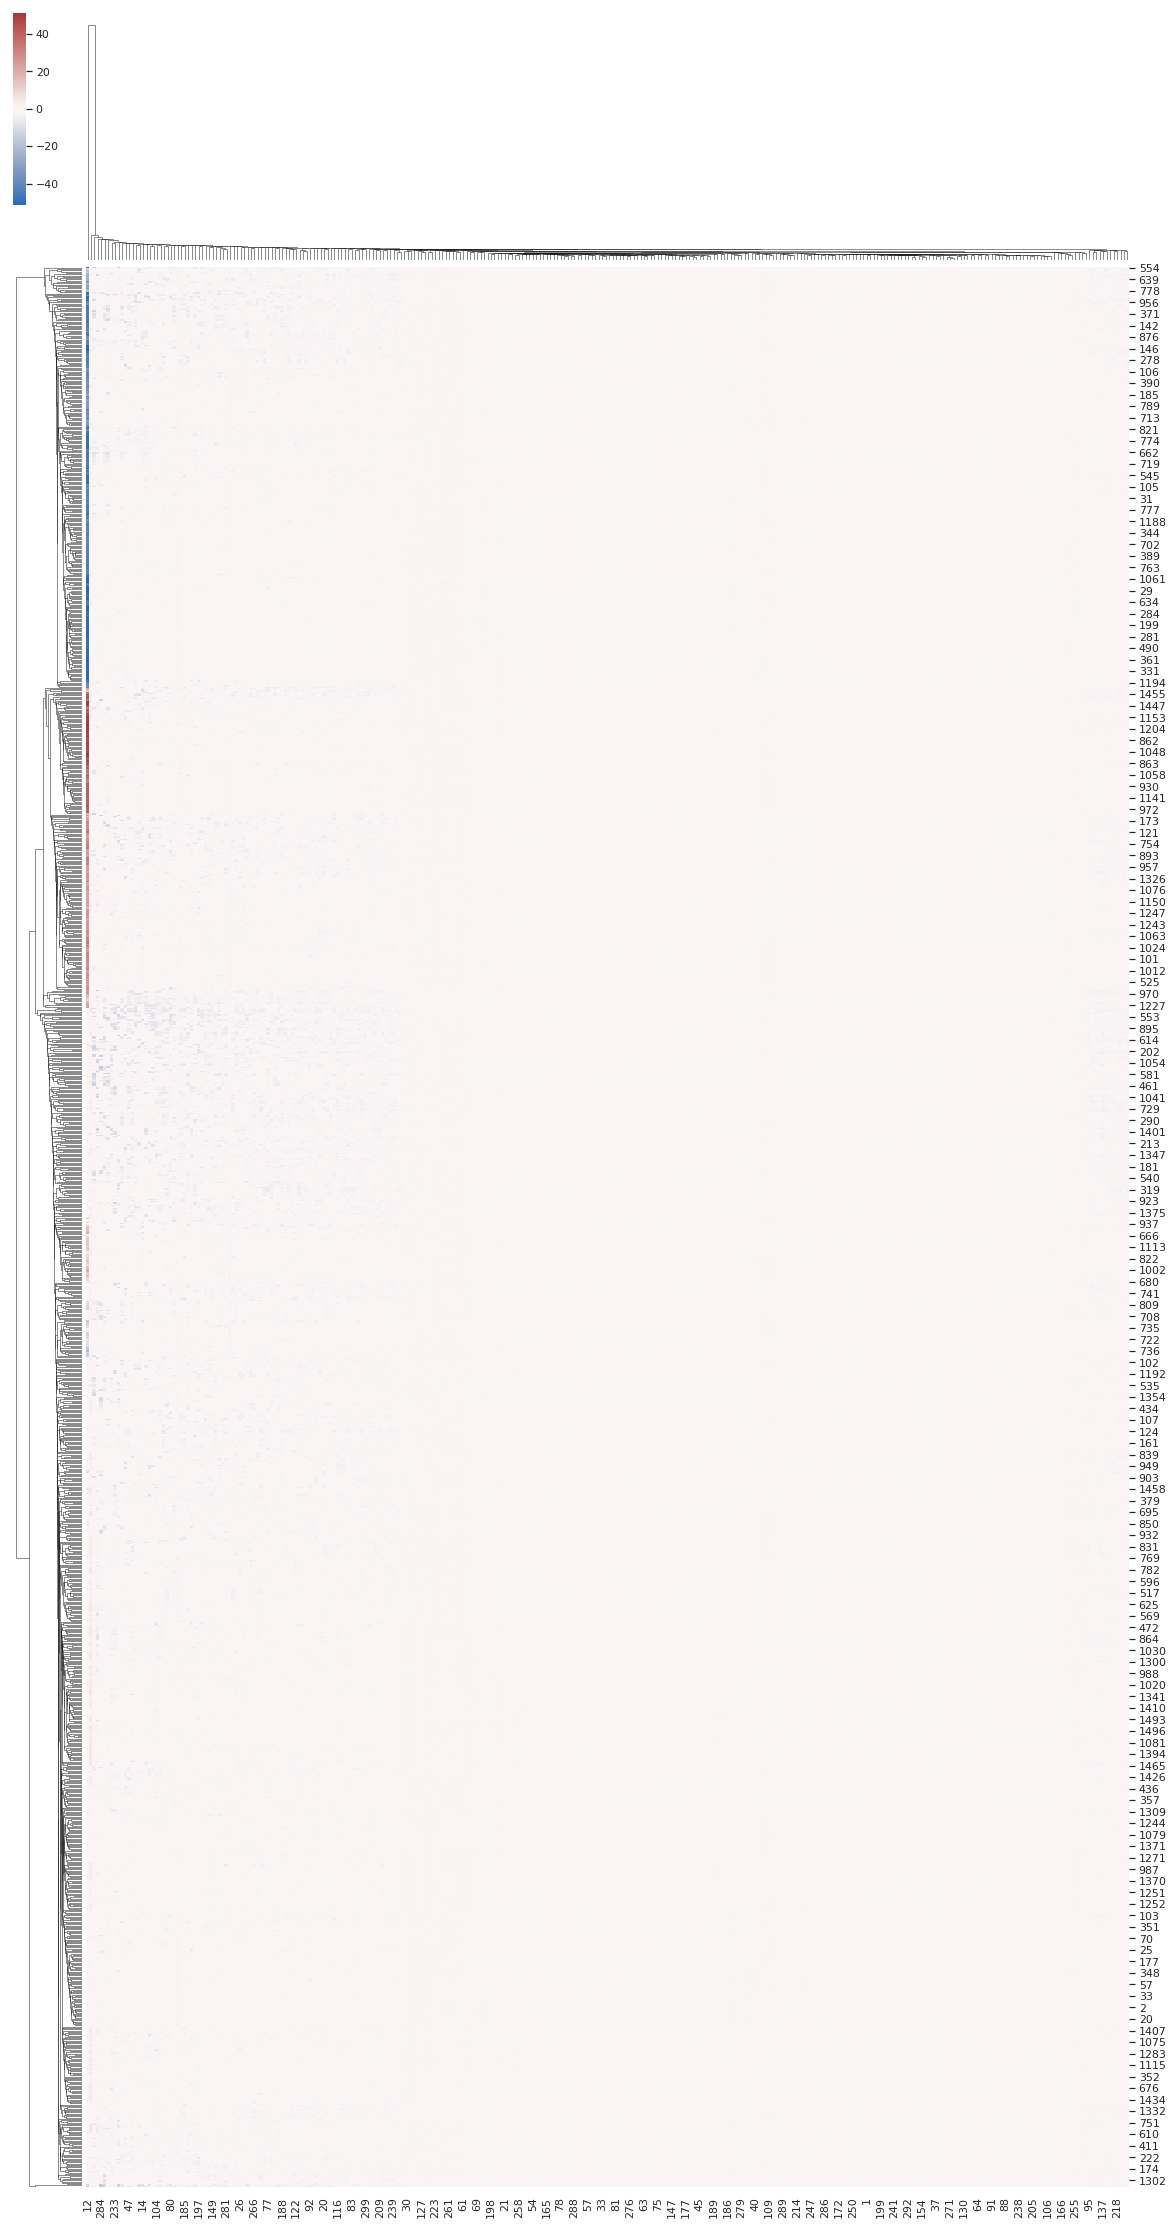

In [80]:
sns.clustermap(simple_process(RSS),figsize=(20,40),cmap='vlag')
sns.clustermap(simple_process(TOA),figsize=(20,40),cmap='vlag')
sns.clustermap(simple_process(DOA),figsize=(20,40),cmap='vlag')

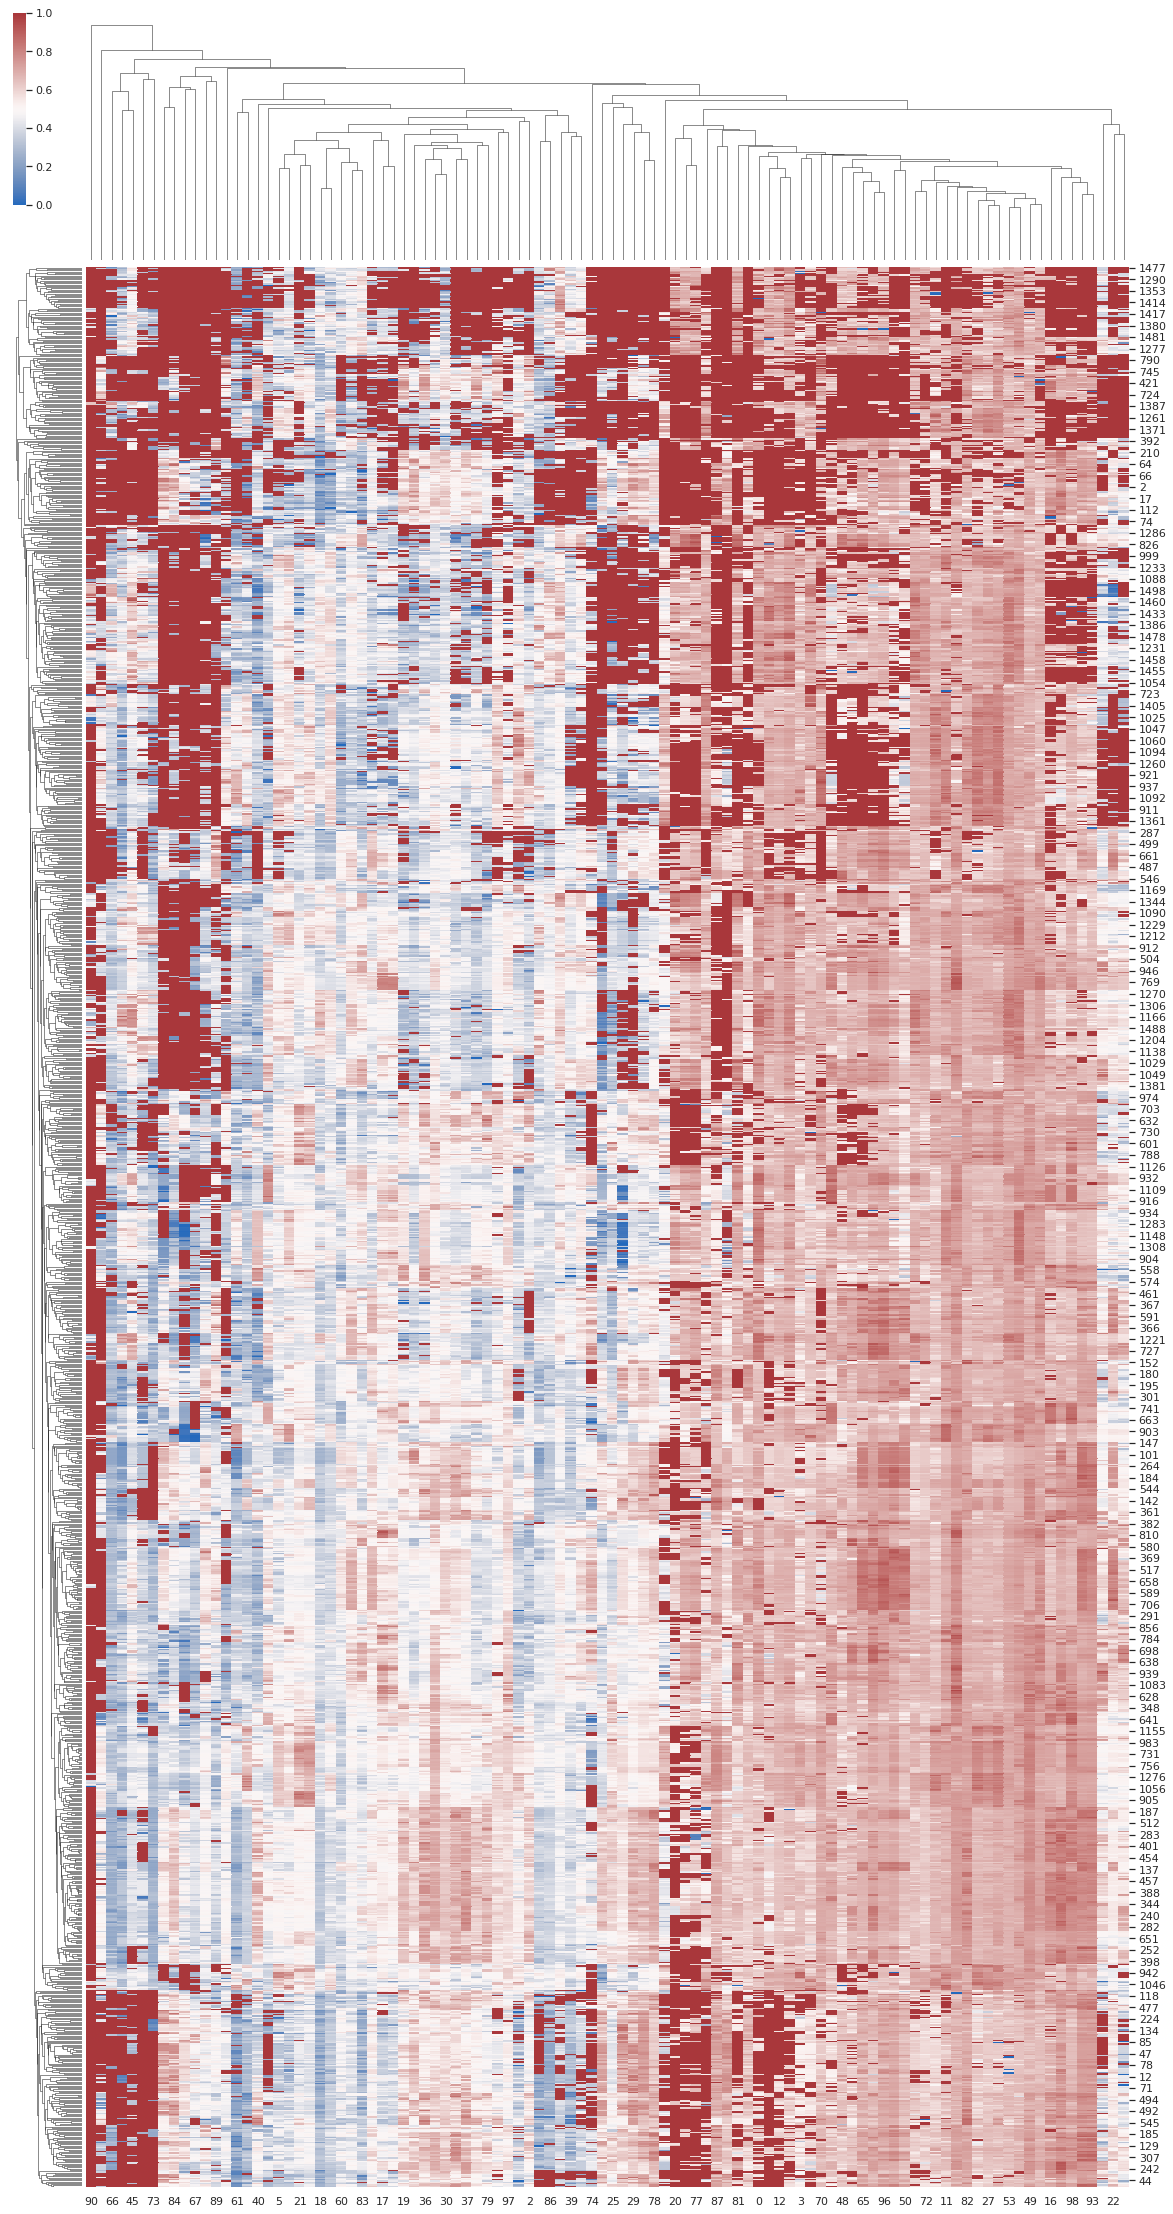

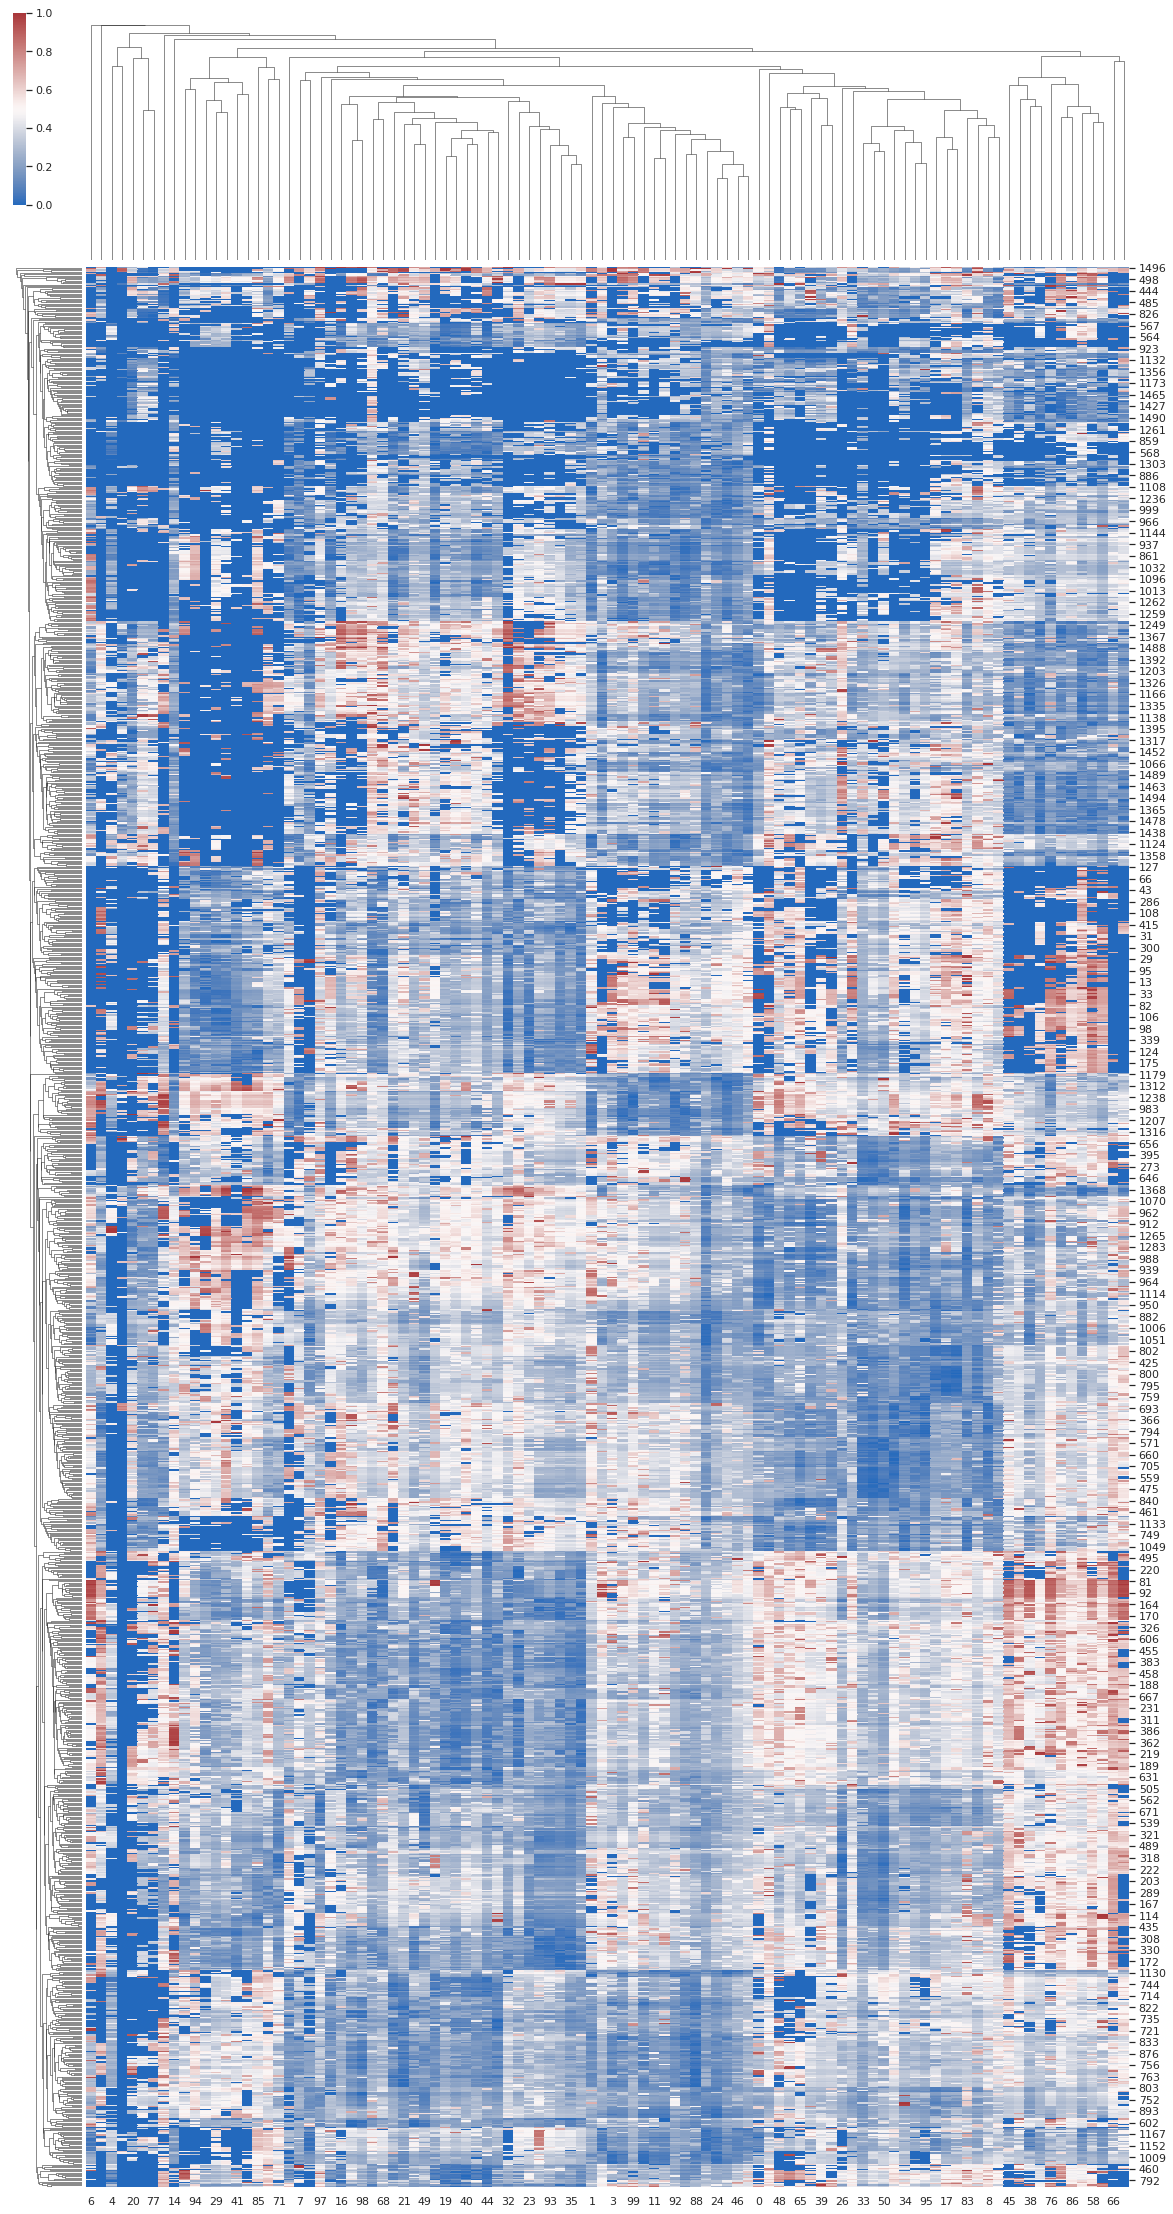

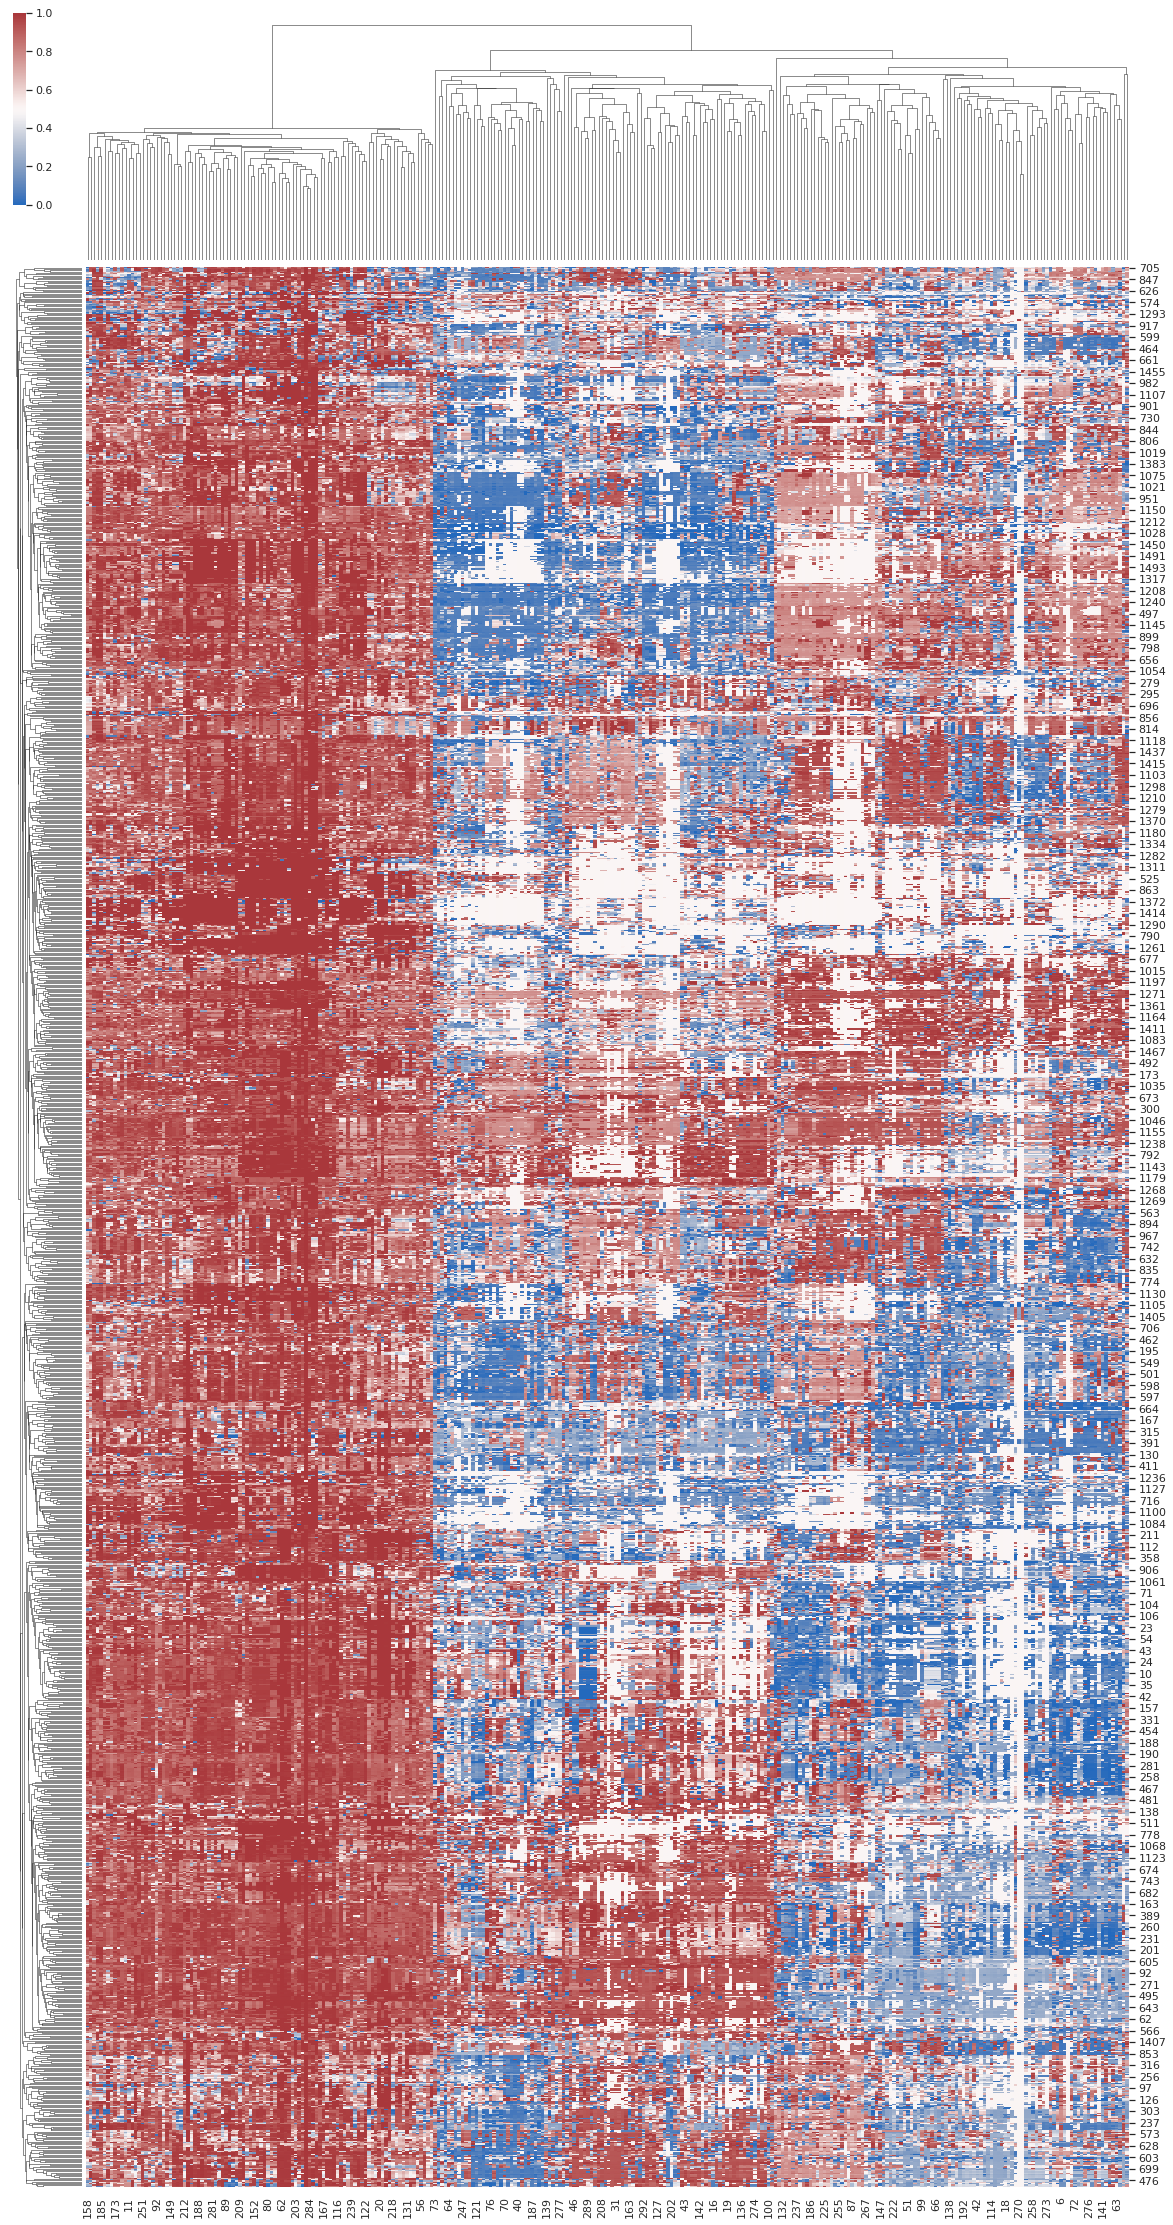

In [79]:
sns.clustermap(simple_process_(RSS),figsize=(20,40),cmap='vlag')
sns.clustermap(simple_process_(TOA),figsize=(20,40),cmap='vlag')
sns.clustermap(simple_process_(DOA),figsize=(20,40),cmap='vlag')